# Pymaceuticals Inc.
---

### Analysis

According to the summary statistics, it appears as though Capomulin and Ramicane are the most successful at reducing tumor volume.  The box plot data showing final tumor volume corroborates this observation.

However, Capomulin and Ramicane also had the highest number of timepoint observations.  This might be because they did more frequent observations over the course of the study, but it might also be because their studies, and therefore treatments, went on for a longer period of time.  If their treatments were performed over a longer period than the other drug regimens, this might skew their final data lower.  This problem might be mitigated by dropping the data where the max timepoint is greater than the max timepoint of the drug regimen with the lowest max timepoint.  However, there is no reference for the measure of the timepoints (is the data in this column representing minutes? Hours? Days?  Did each drug regimen measure their timepoints by the same metric?).  Without answers to those questions, it's hard to really tell which drug regimen did the best.

Regardless, the line chart for capomulin shows a significant drop in tumor volume for one mouse, so it did well there.  It might be more useful to create an aggregate line chart with data for all mice.

The biggest takeaway, though, in my opinion, is the results of the final scatterplot.  There is a reasonably strong correlation between a mouse's weight and the volume of its tumor. Therefore, it is probably safe to assume that a larger mouse will have a larger tumor.  This has big implications for the results of all the other inferences that might be drawn from this data.  For example, if the mice used in the Capomulin study were, on average, smaller than the mice used in the Naftisol study, it would skew the tumor volume average of Capomulin lower than that of Naftisol.  Therefore, it is impossible to truly draw conclusions about the efficacy of the different drug regimens without finding a way to adjust the tumor volume data to account for different mouse weights. 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single DataFrame
mouse_study = pd.merge(mouse_metadata, study_results, how="left", on=["Mouse ID", "Mouse ID"])

# Display the data table for preview
mouse_study.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:
# Checking the number of mice.
mouse_count = len(pd.unique(mouse_study["Mouse ID"]))
mouse_count

249

In [3]:
# Our data should be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
mouse_study[mouse_study.duplicated(["Mouse ID","Timepoint"], keep=False)]

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
duplicate_mouse = mouse_study.loc[mouse_study["Mouse ID"]=="g989"]
duplicate_mouse

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mouse_study.drop(mouse_study.loc[mouse_study["Mouse ID"]=="g989"].index, inplace=True)
mouse_study.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [6]:
# Checking the number of mice in the clean DataFrame.
mouse_count = len(pd.unique(mouse_study["Mouse ID"]))
mouse_count

248

## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.
mean_tumor_volume = mouse_study.groupby("Drug Regimen")["Tumor Volume (mm3)"].mean()
median_tumor_volume = mouse_study.groupby("Drug Regimen")["Tumor Volume (mm3)"].median()
tumor_variance = mouse_study.groupby("Drug Regimen")["Tumor Volume (mm3)"].var()
tumor_stdev = mouse_study.groupby("Drug Regimen")["Tumor Volume (mm3)"].std()
tumor_sem = mouse_study.groupby("Drug Regimen")["Tumor Volume (mm3)"].sem()

summary_statistics = pd.DataFrame({"Mean Tumor Volume":mean_tumor_volume,"Median Tumor Volume":median_tumor_volume,
                                   "Tumor Volume Variance":tumor_variance,"Tumor Volume St. Dev.":tumor_stdev,
                                  "Tumor Volume St. Err.":tumor_sem})
summary_statistics

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume St. Dev.,Tumor Volume St. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [8]:
# A more advanced method to generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen (only one method is required in the solution)

# Using the aggregation method, produce the same summary statistics in a single line
summary_stats = mouse_study.groupby("Drug Regimen")["Tumor Volume (mm3)"].agg(["mean", "median","var","std","sem"])
summary_stats

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

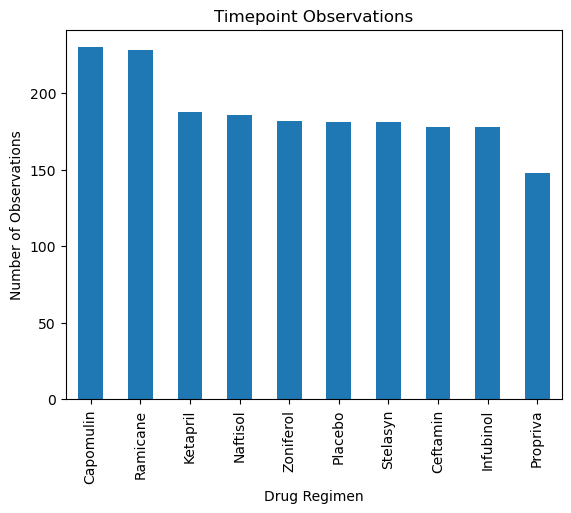

In [9]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.
bar_totals = mouse_study.groupby("Drug Regimen")["Timepoint"].count()
bar_totals = pd.DataFrame(bar_totals)
bar_totals["Timepoint"] = bar_totals["Timepoint"].astype(int)
bar_totals = bar_totals.sort_values("Timepoint",ascending=False)
figure1 = bar_totals.plot(kind = "bar",
                            title = "Timepoint Observations",
                            xlabel = "Drug Regimen",
                            ylabel = "Number of Observations",
                            legend = False)

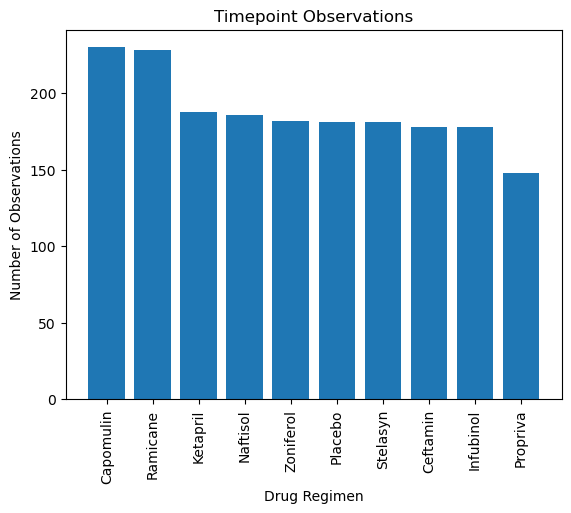

In [10]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.
bar_totals = bar_totals.reset_index()
x_axis = bar_totals["Drug Regimen"]
y_axis = bar_totals["Timepoint"]
plt.bar(x_axis, y_axis)
plt.xticks(rotation="vertical")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Observations")
plt.title("Timepoint Observations")
plt.show()

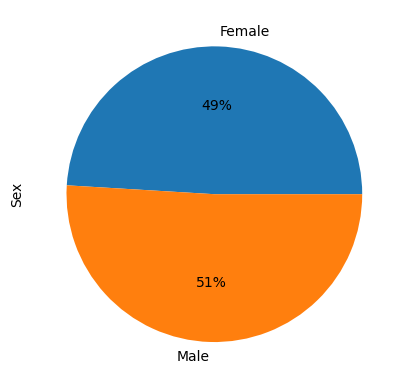

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
pie_totals = mouse_study.groupby("Sex")["Mouse ID"].count()
pie_totals = pd.DataFrame(pie_totals)
pie_totals["Mouse ID"] = pie_totals["Mouse ID"].astype(int)
figure2 = pie_totals.plot(kind = "pie",
                            y = "Mouse ID",
                            autopct='%1.0f%%',
                            ylabel = "Sex",
                            legend = False)

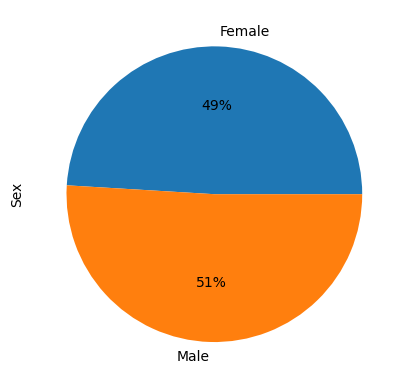

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(pie_totals["Mouse ID"], 
        labels = ["Female","Male"], 
        autopct='%1.0f%%')
plt.ylabel("Sex")
plt.show()

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
max_timepoint = mouse_study.groupby("Mouse ID")["Timepoint"].max().reset_index()

# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
max_timepoint = pd.merge(mouse_study, max_timepoint, how="inner", on=["Timepoint", "Mouse ID"])
max_timepoint

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,45,22.050126,1
1,s185,Capomulin,Female,3,17,45,23.343598,1
2,x401,Capomulin,Female,16,15,45,28.484033,0
3,m601,Capomulin,Male,22,17,45,28.430964,1
4,g791,Ramicane,Male,11,16,45,29.128472,1
...,...,...,...,...,...,...,...,...
243,z314,Stelasyn,Female,21,28,5,45.934712,0
244,z435,Propriva,Female,12,26,10,48.710661,0
245,z581,Infubinol,Female,24,25,45,62.754451,3
246,z795,Naftisol,Female,13,29,45,65.741070,3


In [14]:
# Put treatments into a list for for loop (and later for plot labels)
treatments = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
# Create empty list to fill with tumor vol data (for plotting)
tumor_volume = []
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
    # Locate the rows which contain mice on each drug and get the tumor volumes
for treatment in treatments:
    data = max_timepoint[max_timepoint["Drug Regimen"] == treatment]['Tumor Volume (mm3)']
    quartiles = data.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - 1.5 * iqr
    upper_bound = upperq + 1.5 * iqr
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    # add subset 
    tumor_volume.append(data)
    # Determine outliers using upper and lower bounds
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"The potential outliers for {treatment} are {outliers}.")

Lower bound: 20.70456164999999, Upper bound: 51.83201549
The potential outliers for Capomulin are Series([], Name: Tumor Volume (mm3), dtype: float64).
Lower bound: 17.912664470000003, Upper bound: 54.30681135
The potential outliers for Ramicane are Series([], Name: Tumor Volume (mm3), dtype: float64).
Lower bound: 36.83290494999999, Upper bound: 82.74144559000001
The potential outliers for Infubinol are 74    36.321346
Name: Tumor Volume (mm3), dtype: float64.
Lower bound: 25.355449580000002, Upper bound: 87.66645829999999
The potential outliers for Ceftamin are Series([], Name: Tumor Volume (mm3), dtype: float64).


/var/folders/mz/b_svkd216wddg7tzymnx1w1c0000gn/T/ipykernel_38500/2503634181.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(treatments)


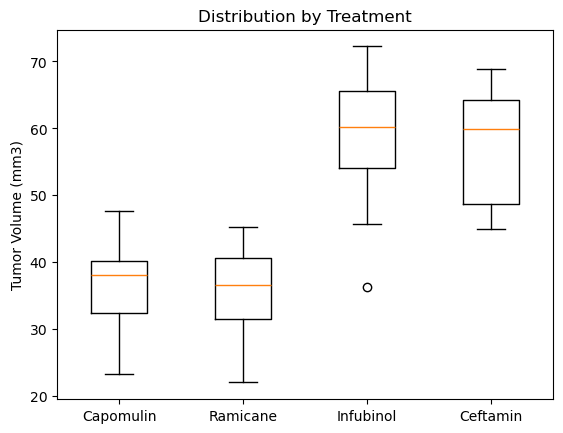

In [15]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.
fig1, ax1 = plt.subplots()
ax1.set_title("Distribution by Treatment")
ax1.set_ylabel("Tumor Volume (mm3)")
ax1.set_xticklabels(treatments)
ax1.boxplot(tumor_volume)
plt.show()

## Line and Scatter Plots

Text(0.5, 1.0, 'Mouse s185 treated with Capomulin.')

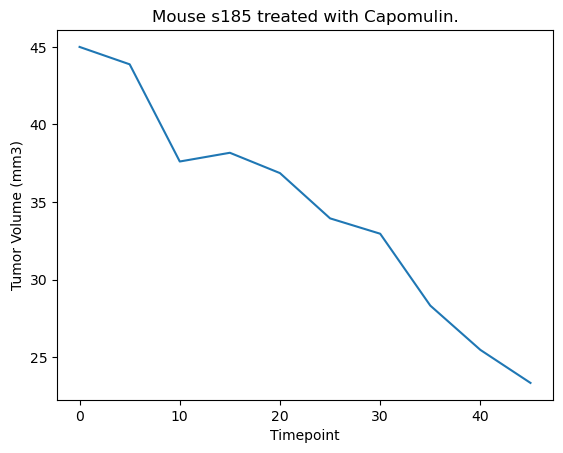

In [16]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin
single_mouse = mouse_study.loc[mouse_study["Drug Regimen"]=="Capomulin"].reset_index()
single_mouse = single_mouse.loc[single_mouse["Mouse ID"]==single_mouse.iloc[0,1]]
single_mouse_reduced = pd.DataFrame( 
    {"Timepoint" : single_mouse["Timepoint"], "Tumor Volume" : single_mouse["Tumor Volume (mm3)"]})
ax = single_mouse_reduced.plot("Timepoint" , "Tumor Volume", legend = False)
ax.set_ylabel("Tumor Volume (mm3)")
ax.set_title("Mouse s185 treated with Capomulin.")

Text(0.5, 0, 'Weight (g)')

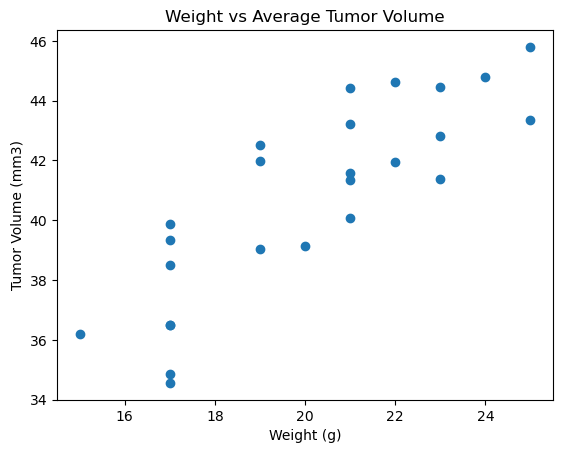

In [17]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen
capomulin_results = mouse_study.loc[mouse_study["Drug Regimen"]=="Capomulin"]
capomulin_avg_tumor_vol = capomulin_results.groupby("Mouse ID")["Tumor Volume (mm3)"].mean()
capomulin_avg_tumor_vol.to_frame()
capomulin_combined = pd.merge(capomulin_avg_tumor_vol,capomulin_results, how = "left", on=["Mouse ID","Mouse ID"])
capomulin_combined.drop_duplicates(subset=["Mouse ID"],inplace = True)
weight = capomulin_combined["Weight (g)"]
tumor_vol = capomulin_combined["Tumor Volume (mm3)_x"]
plt.scatter(weight, tumor_vol, marker="o")
plt.title("Weight vs Average Tumor Volume")
plt.ylabel("Tumor Volume (mm3)")
plt.xlabel("Weight (g)")

## Correlation and Regression

The correlation coefficient between weight and tumor volume is 0.84


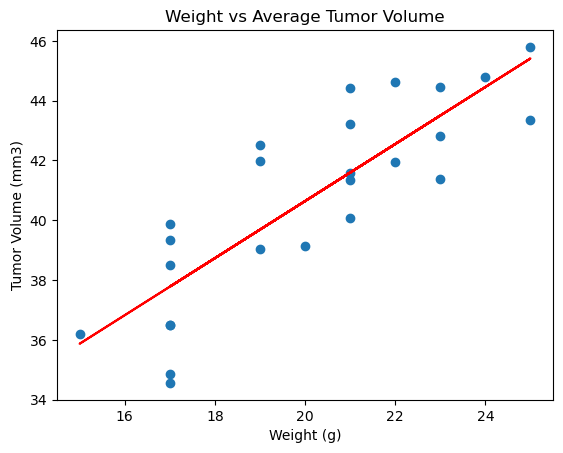

In [18]:
# Calculate the correlation coefficient and a linear regression model 
# for mouse weight and average observed tumor volume for the entire Capomulin regimen
print(f"The correlation coefficient between weight and tumor volume is {round(st.pearsonr(weight, tumor_vol)[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(weight, tumor_vol)
regress_values = weight * slope + intercept
plt.plot(weight,regress_values,"r-")
plt.scatter(weight, tumor_vol, marker="o")
plt.title("Weight vs Average Tumor Volume")
plt.ylabel("Tumor Volume (mm3)")
plt.xlabel("Weight (g)")
plt.show()